In [1]:
import xarray as xr
import geopandas as gpd
from shapely.geometry import Polygon

repo = r"D:\Becas y Proyectos\EY Challenge 2024\EY24"
PR_DS_POST = xr.open_dataset(
    rf"{repo}\data\data_in\Post_Event_San_Juan.tif"
)
PR_DS_PRE = xr.open_dataset(
    rf"{repo}\data\data_in\Pre_Event_San_Juan.tif"
)
BUILDING_GDF = gpd.read_parquet(
    r"D:\Becas y Proyectos\EY Challenge 2024\EY24\data\data_out\BUILDING_GDF.parquet"
)

# Get ds bounds
minx, miny, maxx, maxy = (
    PR_DS_POST.x.min(),
    PR_DS_POST.y.min(),
    PR_DS_POST.x.max(),
    PR_DS_POST.y.max(),
)

# to shapely.Polygon
PR_DS_POST_POLYGON = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

minx, miny, maxx, maxy = (
    PR_DS_PRE.x.min(),
    PR_DS_PRE.y.min(),
    PR_DS_PRE.x.max(),
    PR_DS_PRE.y.max(),
)

# to shapely.Polygon
PR_DS_PRE_POLYGON = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [18]:
import utils
import importlib
importlib.reload(utils)

image, boundaries = utils.stacked_image_from_census_tract(
    dataset=PR_DS_POST,  # FIXME: aca le pódría agregar un polígono de la extension de todo PR y creo que estamos, solo samplea de ahí
    polygon=PR_DS_POST_POLYGON,  # IDEM ACA, cambiar a globales
    img_size=640,
    n_bands=3,
    stacked_images=[1],
)


In [19]:
im_classes, bboxs = utils.get_image_classes_and_boxes(
    BUILDING_GDF, boundaries, 640
)


In [23]:
gdf = gpd.read_file(r"d:\Downloads\building_footprint_roi_challenge_label_reproj.gpkg")

In [27]:
gdf.to_parquet(r"D:\Becas y Proyectos\EY Challenge 2024\EY24\data\data_out\building_footprint_roi_challenge_label_reproj.parquet")

In [33]:
import numpy as np
image_size=512

In [46]:
# initialize iterators & params
bboxs = np.zeros(shape=(0, 4))
image = np.zeros(shape=(3, 0, 0))
img_correct_shape = (3, image_size, image_size)

all_conditions_met = False
# Iterate until the image has the correct shape (when selecting borders)
while all_conditions_met is False:  # or (has_damage is False):

    # Reset conditions
    img_has_correct_shape = False
    img_has_buildings = False
    img_has_damaged_buildings = False

    # Generate the image
    image, boundaries = utils.stacked_image_from_census_tract(
        dataset=PR_DS_POST,  # FIXME: aca le pódría agregar un polígono de la extension de todo PR y creo que estamos, solo samplea de ahí
        polygon=PR_DS_POST_POLYGON,  # IDEM ACA, cambiar a globales
        img_size=image_size,
        n_bands=3,
        stacked_images=[1],
    )
    if boundaries is not None:
        # FIXME: armar estas funciones
        im_classes, bboxs = utils.get_image_classes_and_boxes(
            BUILDING_GDF, boundaries, image_size
        )

        img_has_correct_shape = image.shape == img_correct_shape
        img_has_buildings = bboxs.shape[0] != 0
        img_has_damaged_buildings = utils.assess_image_damage(
            im_classes
        )  # FIXME: for now, it is a pass-through function with all True

    all_conditions_met = all(
        [img_has_correct_shape, img_has_buildings, img_has_damaged_buildings]
    )

# Reduce quality and process image
image = utils.process_image(image, resizing_size=image_size)


<Axes: >

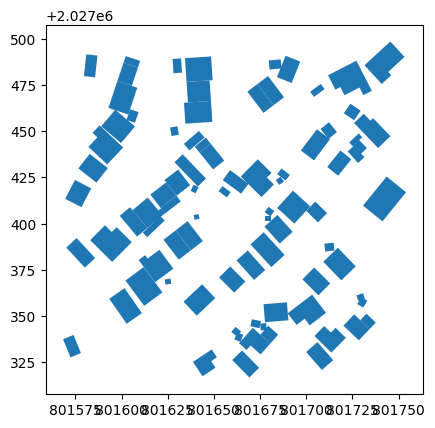

In [67]:
image_buildings = gdf.cx[
    boundaries[0] : boundaries[2], boundaries[1] : boundaries[3]
]
image_buildings.plot()

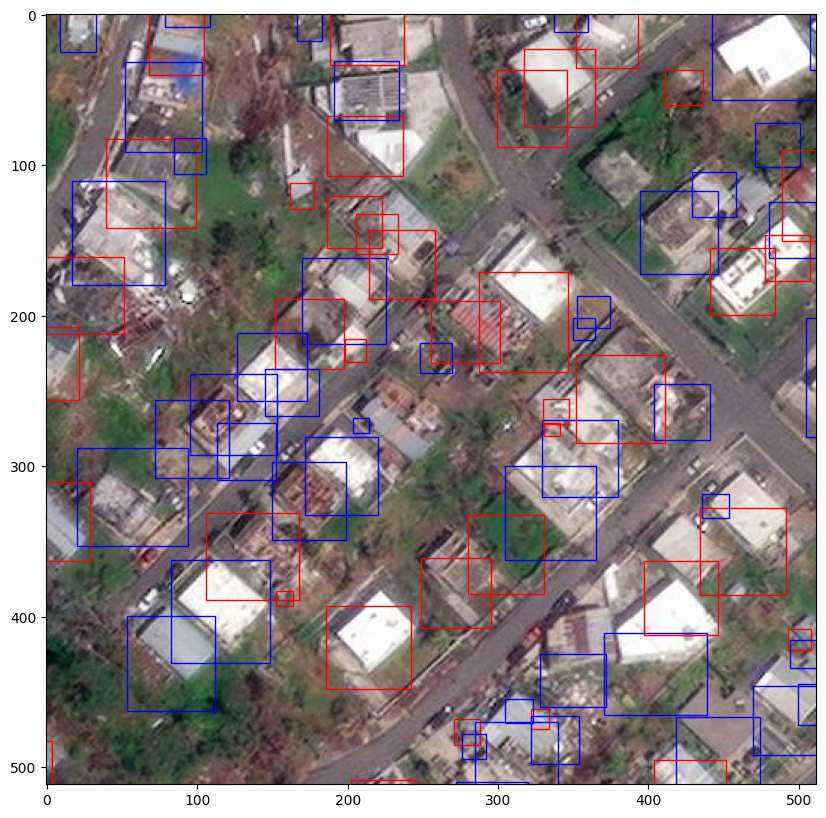

In [64]:
import earthpy.plot as ep
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, bbox in enumerate(bboxs):
    damaged = im_classes[i]
    if damaged:
        edgecolor = "r"
    else:
        edgecolor = "b"
    ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=None, edgecolor=edgecolor))
ax.imshow(image)  # Specify extent here
# axs[0].imshow(np.moveaxis(image, 0, -1))

# ep.plot_rgb(image, ax=axs[0])

In [1]:
import tensorflow as tf
import custom_models

resizing_size = 128
models_dir = "/mnt/"
model = custom_models.efficientnet_v2S(resizing_size, bands=4, kind="reg", weights=None)
model.load_weights(f"/mnt/d/Maestría/Tesis/Repo/data/data_out/models_by_epoch/effnet_v2S_size256_tiles1_sample5/effnet_v2S_size256_tiles1_sample5_100/variables/variables")


2024-02-13 17:34:34.556921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 17:34:35.617065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/nico/miniconda3/envs/tf

In [13]:
ds

<xarray.Dataset>
Dimensions:      (band: 4, x: 30720, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.55 -58.55 -58.55 ... -58.47 -58.47 -58.47
  * y            (y) float64 -34.58 -34.58 -34.58 ... -34.66 -34.66 -34.66
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [8]:
# Identify the non-masked region (where values are not zero)
non_masked = ds.where(ds != 0)

# Get the bounding box of the non-masked region
min_x, max_x = non_masked.x.min(), non_masked.x.max()
min_y, max_y = non_masked.y.min(), non_masked.y.max()

# Subset the xarray dataset to the non-masked region
subset_ds = ds.sel(x=slice(min_x, max_x), y=slice(min_y, max_y))



MemoryError: Unable to allocate 14.1 GiB for an array with shape (4, 30720, 30720) and data type float32

In [ ]:
subset_ds

In [27]:
import build_dataset
datasets, extents = build_dataset.load_landsat_datasets()
icpag = build_dataset.load_icpag_dataset()

KeyboardInterrupt: 

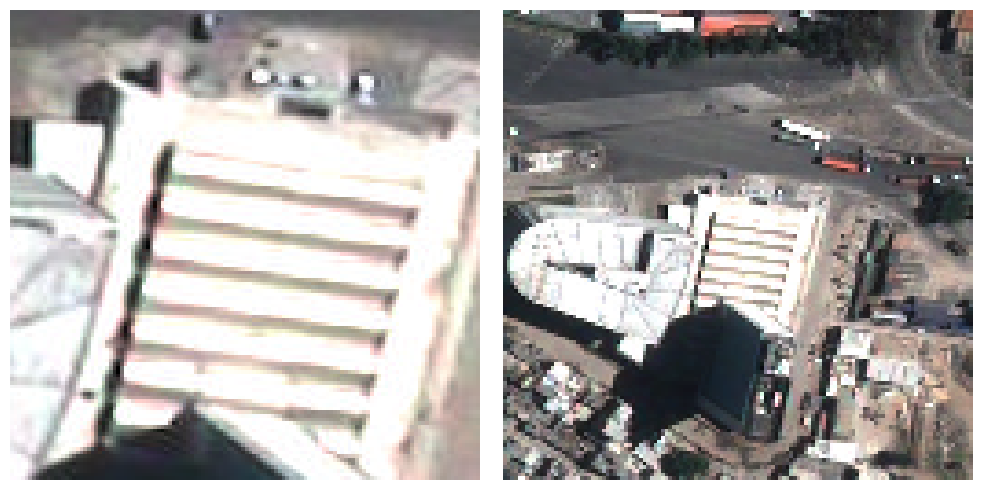

In [12]:
import numpy as np
import matplotlib.pyplot as plt
image = np.load(r"D:/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_maybe_working_test_example_4_imgs.npy")

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(image[0,:,:,0:3])
axs[1].imshow(image[0,:,:,4:7])
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()

In [5]:
icpag["dataset_2013"] = "LC08_225084_20130725"

In [28]:
datasets, extents = build_dataset.load_landsat_datasets()

ds = datasets["LC08_225084_20130725"]

In [29]:
import numpy as np

In [30]:
df_subset = icpag
all_years_datasets = {}
all_years_datasets[2013] = datasets
import random
import utils
nbands=11
stacked_images = [1]
image_size=32
resizing_size=32
# def get_data(i, df_subset, type="train", load=False):
    # Decoding from the EagerTensor object. Extracts the number/value from the tensor
    #   example: <tf.Tensor: shape=(), dtype=uint8, numpy=20> -> 20

year = random.choices(
    population=list(all_years_datasets.keys()),
    weights=[1],
    k=1
)[0]
sat_img_dataset = all_years_datasets[year]
# initialize iterators & params
iteration = 0
is_correct_type = False
image = np.zeros(shape=(nbands, 0, 0))
total_bands = nbands * len(stacked_images)
img_correct_shape = (total_bands, image_size, image_size)
i=500

# Get link, dataset and indicator value of the corresponding index
polygon = df_subset.iloc[i]["geometry"]
value = df_subset.iloc[i]["var"]
link_dataset = sat_img_dataset[df_subset.iloc[i][f"dataset_{year}"]]

while (is_correct_type == False) & (iteration<=5):

    # Generate the image
    image, boundaries = utils.stacked_image_from_census_tract(
        dataset=link_dataset,
        polygon=polygon,
        img_size=image_size,
        n_bands=nbands,
        stacked_images=stacked_images,
    )

    # (1) Image has to have the correct shape
    if image.shape == img_correct_shape:
        # (2) Image has to fall in train or test side
        is_correct_type = build_dataset.assert_train_test_datapoint(
            boundaries, wanted_type=type
        )

    iteration +=1

if iteration>=5:
    print(f"More than 5 interations for link {df_subset.iloc[i]['link']}, moving to next link...")
    # image = np.zeros(shape=(resizing_size, resizing_size, total_bands))
    # value = 0
    # return image, value

# # Reduce quality and process image
# image = utils.process_image(image, resizing_size=resizing_size)

# # Augment dataset
# if type == "train":
#     image = utils.augment_image(image)
#     # image = image

# np.save(fr"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_arrays/img_{i}_{df_subset.iloc[i].link}.npy", image)
# return image, value

# image, value = get_data(200, df_subset, type="train", load=False)

More than 5 interations for link 020022406, moving to next link...


In [120]:
from skimage import exposure
import xarray as xr
bands = ds.band.values
x = ds.x.values
y = ds.y.values
sr = ds.spatial_ref.values 
band_data = exposure.equalize_hist(ds.band_data.to_numpy())
band_data = exposure.adjust_gamma(band_data, 1.2)
band_data = xr.DataArray(band_data, coords={'band': bands, 'x': x, 
                                'y': y, 'spatial_ref':sr},
             dims=['band', 'y', 'x'])
ds["band_data"] = band_data


In [2]:
import build_dataset

datasets, extents = build_dataset.load_landsat_datasets()

ds = datasets["LC08_225084_20130725"]

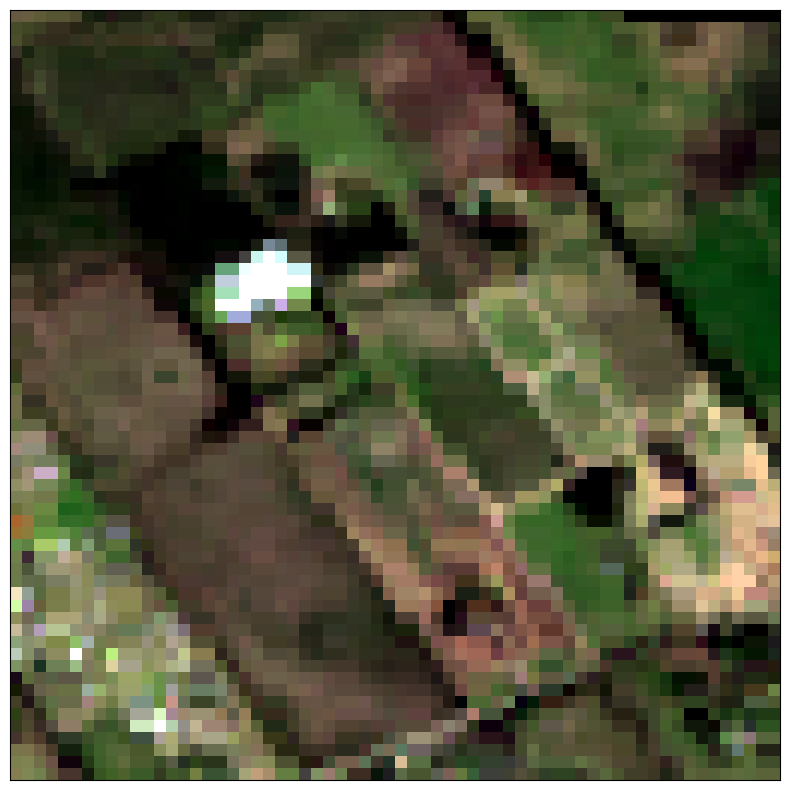

<Axes: >

In [7]:
import cv2
import numpy as np
import earthpy.plot as ep
im = ds.isel(y=slice(0, 64), x=slice(0, 64)).band_data.astype(np.uint8).to_numpy()
# im = utils.process_image(im, 124)
ep.plot_rgb(im, rgb=(3,2,1))

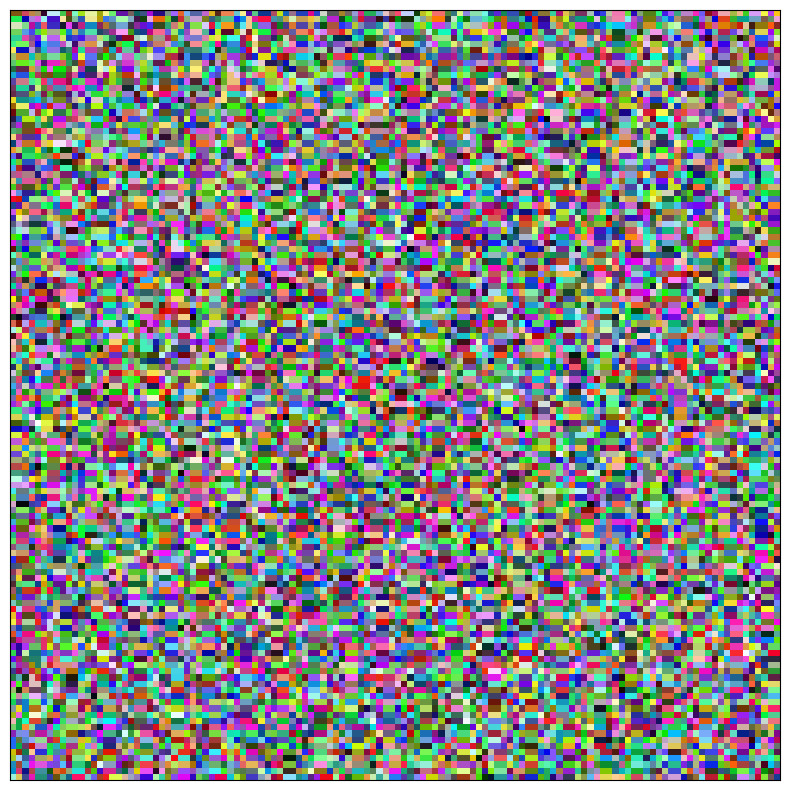

<Axes: >

In [80]:
import earthpy.plot as ep
ep.plot_rgb(image,rgb=(3, 2, 1))

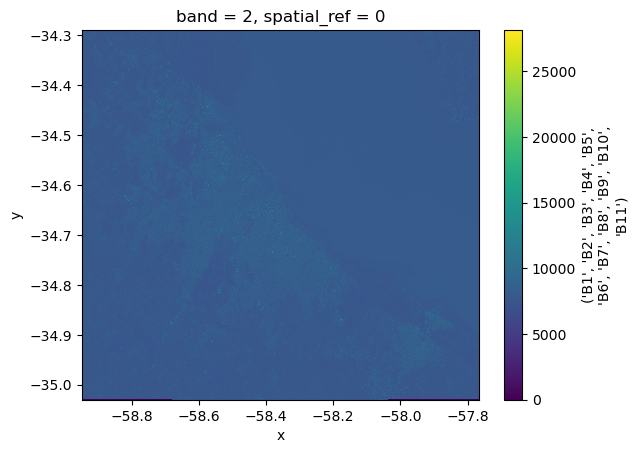

In [31]:
datasets["LC08_225084_20130725"].sel(band=2).band_data.plot()

In [ ]:
import build_dataset
import utils
from importlib import reload

# Load datasets
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=False)


In [1]:
import build_dataset
build_dataset.load_icpag_dataset(variable="ln_pred_inc_mean", trim=True)

2024-01-04 12:13:14.942417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 12:13:15.962818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-01-04 12:13:17.300788: I

,index,link,AREA,PERIMETER,PAISXRAD10,PAISXRAD_1,PROV,DEPTO,FRAC,RADIO,TIPO,link_dpto,departamen,provincia,eph_codagl,eph_aglome,codaglo,aglomerado,aglo_eph,AMBA_legal,rmin,rmax,rminp50,rminp25,rminp75,rmaxp50,rmaxp25,rmaxp75,p_usd,pm2,obs_pm2,pm2_2019,obs_pm2_19,p_usd_2019,personas,viv_part,lvp1bvp50,lvpra_1bvp,lvprf_1bvp,lvp1bv,lvpra_1bv,lvprf_1bv,superficie,den_p,rural1,rural2,urbano,mergelvp,objectid_1,cod_fra,provdep,oid_,objectid,link_1,cod_fra_1,provdep_1,indicetmi,rrbn,rrsc,pa_complem,varon,mujer,totalpobl,poblnoasis,poblmenpri,f_edmen1ri,indedmen1r,univcompl,f_edunv,indeduniv,pobhogpart,hacinam,f__hacinam,indhacinam,sinretrete,f__sinretr,indsinretr,poblsinobr,inundsi,inundno,inundtotal,basusi,basuno,basutotal,villasi,villano,villatotal,var¥n,mujer1,totalpob_1,f_pobinund,f_pobbasu,f_pobvilla,indinund,indbasu,indvilla,indpa,p1305,link2,f_sobsocia,indobsoc,icv2010,mergeicv,cprov,nprov,CicvNr,CicvNp,CicvNv,CrmaxNr,CrmaxNp,CrmaxNv,Crmaxp50Nr,Crmaxp50Np,Crmaxp50Nv,Crmaxp25Nr,Crmaxp25Np,Crmaxp25Nv,Crmaxp75Nr,Crmaxp75Np,Crmaxp75Nv,CicvPr,CicvPp,CicvPv,CrmaxPr,CrmaxPp,CrmaxPv,Crmaxp50Pr,Crmaxp50Pp,Crmaxp50Pv,Crmaxp25Pr,Crmaxp25Pp,Crmaxp25Pv,Crmaxp75Pr,Crmaxp75Pp,Crmaxp75Pv,tasa_activ,tasa_emple,tasa_desoc,total,total_val,con_nbi,sin_nbi,nbi_rc,nbi_rc_val,icpagNabs,CicpagNv,icpag,geometry,pred_inc_mean,ln_pred_inc_mean,pred_inc_p50,ln_pred_inc_p50,var
0,1,020010201,27667.875,921.090,31535,31535,2,1,2,1,U,2001,Comuna 1,Ciudad Autónoma de Buenos Aires,1.0,CABA,1.0,Gran Buenos Aires,1,1,0.619610,0.280022,0.681818,0.820180,0.453476,0.242412,0.426968,0.050497,NaN,NaN,NaN,NaN,NaN,NaN,478.0,148.0,10.844771,10.831049,10.777167,10.877172,10.867416,10.813536,27321.00,174.956993,0.0,0.0,1.0,3,0.0,200102,2001,49493.0,49494.0,20010201,200102,2001,0.911244,3.75,9.0,0.00,0.0,0.0,11243.0,245.0,24.0,9.795918,0.821728,7.0,2.857143,0.062937,473.0,222.0,46.443515,0.487223,73.0,15.271967,0.646930,271.0,2417.0,8753.0,11170.0,7136.0,4034.0,11170.0,10991.0,179.0,11170.0,5633.0,5610.0,11243.0,21.497821,63.470604,97.758605,0.607274,-0.177562,-0.421323,0.002796,478.0,20010201.0,2.410389,0.969388,5.180043,3,2.0,2.0,5.0,5.0,4.0,48.0,49.0,39.0,50.0,51.0,41.0,48.0,48.0,39.0,37.0,37.0,30.0,3.0,5.0,3.0,4.0,6.0,3.0,4.0,7.0,3.0,4.0,6.0,3.0,3.0,4.0,2.0,70.45,66.87,5.08,162,161.0,43,118,0.265432,0.267081,-1.199170,7.0,0.07,"POLYGON ((-58.38915 -34.57818, -58.38888 -34.5...",621.090332,6.222483,544.032959,6.299010,-0.528243
1,2,020010202,17843.625,770.726,31544,31544,2,1,2,2,U,2001,Comuna 1,Ciudad Autónoma de Buenos Aires,1.0,CABA,1.0,Gran Buenos Aires,1,1,0.560548,0.220684,0.588210,0.783884,0.348708,0.142617,0.360114,0.024011,NaN,NaN,NaN,NaN,NaN,NaN,401.0,124.0,10.844771,10.826484,10.772602,10.848619,10.835356,10.781474,17702.00,226.528076,0.0,0.0,1.0,3,0.0,200102,2001,49500.0,49501.0,20010202,200102,2001,0.911244,3.75,9.0,0.00,0.0,0.0,11243.0,210.0,30.0,14.285714,0.726282,2.0,0.952381,0.017651,401.0,266.0,66.334165,0.231428,8.0,1.995012,0.958157,257.0,2417.0,8753.0,11170.0,7136.0,4034.0,11170.0,10991.0,179.0,11170.0,5633.0,5610.0,11243.0,21.497821,63.470604,97.758605,0.607274,-0.177562,-0.421323,0.002796,401.0,20010202.0,2.285867,0.970969,5.096323,3,2.0,2.0,5.0,4.0,3.0,37.0,37.0,29.0,34.0,33.0,26.0,40.0,40.0,31.0,24.0,23.0,18.0,3.0,5.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,4.0,2.0,1.0,2.0,1.0,66.17,60.53,8.52,132,128.0,26,102,0.196970,0.203125,-1.224758,7.0,0.07,"POLYGON ((-58.38836 -34.57901, -58.38903 -34.5...",555.298645,6.122287,510.413269,6.235210,-0.733504
2,3,020010203,11074.875,527.720,31609,31609,2,1,2,3,U,2001,Comuna 1,Ciudad Autónoma de Buenos Aires,1.0,CABA,1.0,Gran Buenos Aires,1,1,0.600326,0.253551,0.625186,0.817743,0.436993,0.178219,0.445302,0.042534,NaN,NaN,NaN,NaN,NaN,NaN,337.0,104.0,10.763831,10.745989,10.692107,10.855235,10.840245,10.786364,10962.88,307.400975,0.0,0.0,1.0,3,0.0,200102,2001,49528.0,49529.0,20010203,200102,2001,0.911244,3.75,9.0,0.00,0.0,0.0,11243.0,186.0,21.0,11.290323,0.789959,5.0,2.688172,0.058920,337.0,189.0,56.083086,0.363258,14.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
"D:\Maestría\Tesis\Repo\data\data_out\test_datasets\test_size128_tiles1_stacked1\test_020010205.npy"
train = np.load(r"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_size128_tiles1_stacked1/test_020010205.npy")
pics = train.shape[0]
fig, axs = plt.subplots(pics, 1, figsize=(6, 6*pics))
for i in range(pics):
    axs[i].imshow(train[i][:,:,:3])



In [ ]:
from shapely import Point
point = Point(10, -20)

In [ ]:
import run_model
reload(run_model)
run_model.get_data(10, icpag, load=True, type="test",)

In [ ]:
link = icpag.sample(1).link.values[0]
ds = build_dataset.get_dataset_for_link(icpag, datasets, link)

In [ ]:
icpag[icpag.link == link].geometry.values[0]

In [ ]:
import run_model
run_model.create_train_test_dataframes(small_sample=False)


In [ ]:
import build_dataset
import geopandas as gpd
sat_img_datasets, extents = build_dataset.load_satellite_datasets()
# df_test = gpd.read_feather(rf"{path_dataout}/test_datasets/test_dataframe.feather")


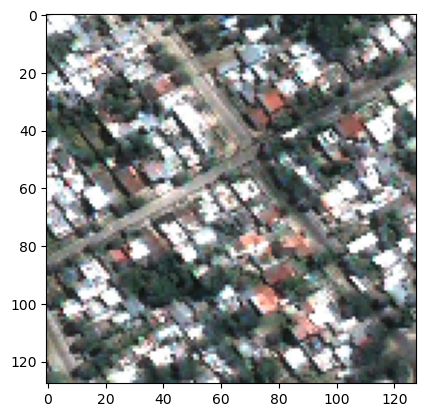

In [11]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.load(r"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_size384_tiles1_stacked1/test_068051414.npy")
plt.imshow(arr[1,:,:,:3])

In [6]:
from shapely import Polygon
P = Polygon([[0, 0], [1, 0], [1, 1], [0, 1]])

P.centroid.x


0.5

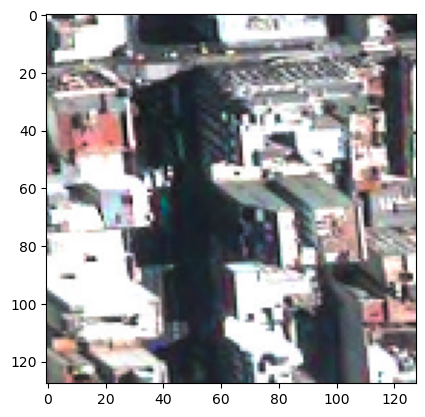

In [21]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/test_example_1_imgs.npy")
plt.imshow(arr[1,:,:,:3])

In [ ]:
df_test = gpd.read_feather(rf"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_dataframe.feather")
# 

In [1]:
import compute_true_loss
import importlib

compute_true_loss.compute_custom_loss_all_epochs(
    models_dir=r"/mnt/d/Maestría/Tesis/Repo/data/data_out/models_by_epoch/mobnet_v3_size128_tiles1_sample5",
    model_name="mobnet_v3_size128_tiles1_sample5",
    tiles=1,
    size=128,
    resizing_size=128,
    n_epochs=200,
    n_bands=4,
    stacked_images=[1],
    verbose=True
)

2023-12-03 21:06:39.736176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 21:06:41.727514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/nico/miniconda3/envs/tf

KeyboardInterrupt: 

In [ ]:
folder, links = compute_true_loss.generate_gridded_images(
    tiles=1,
    size=128,
    resizing_size=128,
    n_bands=4,
    stacked_images=[1],
)

In [ ]:
df_test.loc[df_test["link"]==20010201, "geometry"].item()


In [ ]:
df_test["link"]

In [ ]:
a = [1,2]
'_'.join(str(x) for x in a)


In [ ]:
test = ds
test.where(test.band_data<100,100)

In [ ]:
ds.isel(x=slice(0,100), y=slice(0,100)) - 200

In [ ]:
ds.band_data.isel(x=slice(0,10000), y=slice(0,10000)).min()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

fig, ax = plt.subplots(1,2, figsize=(12,6))

clip_img_a = image[:3,:,:]
clip_img_a = np.moveaxis(clip_img_a,0,2)
clip_img_a = skimage.exposure.equalize_hist(clip_img_a)
ax[0].imshow(clip_img_a)

clip_img_b = image[4:7,:,:]
clip_img_b = np.moveaxis(clip_img_b,0,2)
clip_img_b = skimage.exposure.equalize_hist(clip_img_b)
ax[1].imshow(clip_img_b)
clip_img_a.shape

In [ ]:
def stretch(image, minimum, maximum):
    image = (image - minimum) / (maximum - minimum)
    image[image < 0] = 0
    image[image > 1] = 1
    return image


In [ ]:
ds[ds<100]

In [ ]:
ds - ds.band_data.min()

In [ ]:
stretch(ds, ds

In [ ]:
plt.imshow(image)

In [ ]:
mnist = tf.keras.datasets.mnist

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(dataset, epochs=5)


In [ ]:
train_data

In [ ]:
type(x_train)

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
%tensorboard

In [ ]:
import build_dataset

census_data = build_dataset.load_icpag_dataset(variable="ln_pred_inc_mean")

In [ ]:
import run_model

df_train, df_test, sat_img_dataset = run_model.create_train_test_dataframes(
        small_sample=False
    )



In [ ]:
df_test.explore()

In [ ]:
df_train.explore()

In [ ]:
census_data.to_parquet("census_data.parquet")

In [ ]:
import tensorflow as tf
import tensorboard as tb
import numpy as np

# Extract data from TB
experiment_id = "RAqyLXG2RMKkAXMmNEDV7Q"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

for kind in ["train", "validation"]:
    # Keep only train values
    base = df[df.run.str.contains(f'{kind}') & (df.tag == 'epoch_loss')]
    base['run'] = base.run.str.replace(f"/{kind}", "")

    # Filter model
    models_by_date = { 
        'mobnet_v3_size128_tiles1_sample1':
            [
                'mobnet_v3_20230908-203439',
                'mobnet_v3_20230909-020833',
                'mobnet_v3_20230909-121048',
                'mobnet_v3_20230909-153231',
                'mobnet_v3_20230909-202517',
                'mobnet_v3_20230909-213040',
                'mobnet_v3_20230910-130103',
                'mobnet_v3_20230911-092415',
                'mobnet_v3_20230911-231611',
                'mobnet_v3_20230912-012855',
            ],
        'mobnet_v3_size256_tiles1_sample1':
            [       
                'mobnet_v3_20230914-215006',
                'mobnet_v3_20230913-200010',
            ],      
        'mobnet_v3_size512_tiles1_sample1':
            [
                'mobnet_v3_20230915-122541',
                'mobnet_v3_20230916-124818',
            ],
        'mobnet_v3_size128_tiles2_sample20':
            [
                'mobnet_v3_20230918-192554',
                'mobnet_v3_20230918-231134',
                'mobnet_v3_20230919-104912',
                'mobnet_v3_20230919-234505',
                'mobnet_v3_20230920-131123',
                'mobnet_v3_20230920-180458',
                'mobnet_v3_20230920-194725',
            ]
    }

    base['model'] = np.nan
    for model, names in models_by_date.items():
        for name in names:
            base.loc[base.run.str.contains(name), 'model'] = model
            
    # Reshape data
    plot_data = base[~base.model.isna()]\
        .drop_duplicates(subset=['model','step'], keep='first')\
        .pivot(index='step', columns='model', values='value')
        
    # Export data
    path_repo = r"D:/Maestría/Tesis/Repo"
    plot_data.to_csv(f"{path_repo}/data/data_out/{kind}_by_epoch.csv")

In [ ]:
kind

In [ ]:
plot_data

In [ ]:
import numpy as np
import os
from tqdm import tqdm
path = r"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_size128_tiles1_stacked1"
files = os.listdir(path)

data = {}
for file in tqdm(files):
    link = file[5:14]
    data[link] = np.load(fr"{path}/{file}")

In [ ]:
"test_060283610.npy"[5:14]

In [ ]:
655360

In [ ]:
import importlib
import pandas as pd
import tensorflow as tf

import utils
import build_dataset as bd
import run_model

importlib.reload(run_model)
importlib.reload(utils)

path_repo = r"/mnt/d/Maestría/Tesis/Repo/"

log_dir = f"{path_repo}/logs/mobnet_v3_20230905-231447"
models_dir = f"{path_repo}/data/data_out/models_by_epoch"
model_name = "mobnet_v3"
metadata = pd.read_csv(f"{path_repo}/data/data_out/size128_sample10/metadata.csv")
tiles = 1
size = 128
resizing_size = 128
bias = 2
sample = 1
to8bit = True
n_epochs = 20


# modelpath = rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_25"
# model = tf.keras.models.load_model(
#            modelpath, compile=True
#         )
# metadata = metadata.loc[metadata.type == "test", "link"]
# df_prediciones, mse = run_model.compute_custom_loss(
#     model, metadata, tiles, size, resizing_size, bias, sample, to8bit
# )

In [ ]:
%tensorboard

In [ ]:
import xarray as xr
import os
path_pansharpened = r"D:\Maestría\Tesis\Repo\data\data_in\Pansharpened\2013"
files = os.listdir(path_pansharpened)
tifs = [f for f in files if f.endswith(".tif")]
tifs

ds1 = xr.open_dataset(rf"{path_pansharpened}\{tifs[0]}")
ds2 = xr.open_dataset(rf"{path_pansharpened}\{tifs[1]}")

In [ ]:
xr.combine_by_coords([ds1, ds2])

In [ ]:
df_prediciones, mse = run_model.compute_custom_loss(
    model, metadata[metadata.link == int(64100610)], tiles, size, resizing_size, bias, sample, to8bit
)

In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
import numpy as np
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(utils)

# # Load datasets
xr_datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=True)



In [ ]:
icpag.iloc[100]

In [ ]:
np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/train_example_0_imgs.npy")

In [ ]:
utils.stacked_image_from_census_tract(xr_datasets[icpag.iloc[100].dataset], icpag.iloc[100].geometry, img_size=100, n_bands=4, stacked_images=[1,3])

In [ ]:
# importlib.reload(run_model)
# import run_model
# test = run_model.create_datasets(image_size=512, resizing_size=128, batch_size=1, save_examples=True)

In [ ]:
## TODO:
# 1) Agregar visuzliación de imahgenes
# 2) Split train test bien 
# 3) Ver si se puede optimizar random_image_from_census_tract

In [ ]:
image_size=512
resizing_size=128
batch_size=1
small_sample=False
save_examples=True

# Based on: https://medium.com/@acordier/tf-data-dataset-generators-with-parallelization-the-easy-way-b5c5f7d2a18

def get_data(i):
    # Decoding from the EagerTensor object. Extracts the number/value from the tensor
    #   example: <tf.Tensor: shape=(), dtype=uint8, numpy=20> -> 20
    i = i.numpy()

    # Get link, dataset and indicator value of the corresponding index
    link = df_train.iloc[i]["link"]
    value = df_train.iloc[i]["var"]
    link_dataset = xr_datasets[df_train.iloc[i]["dataset"]]

    # Generate the image
    image, point, bounds, total_bounds = utils.random_image_from_census_tract(
        link_dataset, df_train, link, tiles=g_tiles, size=g_image_size, bias=2
    )
    
    if image is not None:
        # Process image
        image = np.moveaxis(image, 0, 2)

        # Augment some shit
        # ... TODO
        #   Resize (g_resize)

        # Assert that data corresponds to train or test
        is_correct_type = build_dataset.assert_train_test_datapoint(
            point, total_bounds, wanted_type="train"
        )
        if is_correct_type == False:  # If the point is not train/test, discard it
            image = 0
            value = np.nan
            print("Imagen eliminada por type")

    else:
        # Value nan gets filtered later!
        image = 0
        value = np.nan
        print("Imagen eliminada por None")
        
    return image, value

def get_train_data(i):
    image, value = get_data(i, df_train)
    return image, value

def get_test_data(i):
    image, value = get_data(i, df_test)
    return image, value

def _fixup_shape(x, y):
    """Note that you may need to add the following mapping right after batching, since in some cases
    (depending on the layers used in the trained model and your version of TensorFlow) the implicit
    inferring of the shapes of the output Tensors can fail due to the use of .from_generator()
    """
    x.set_shape([None, None, None, 4])  # n, h, w, c
    y.set_shape([None, 1])  # n, nb_classes
    return x, y

g_tiles = 1
g_image_size = 512

### Open dataframe with files and labels
print("Reading dataset...")
xr_datasets, extents = build_dataset.load_satellite_datasets()
df = build_dataset.load_icpag_dataset()
df = build_dataset.assign_links_to_datasets(df, extents, verbose=True)
print("Dataset loaded!")

print("Cleaning dataset...")
# Clean dataframe and create datasets
# df = df[df["sample"] <= 2]
if small_sample:
    df = df.sample(2000, random_state=825).reset_index(drop=True)

### Split census tracts based on train/test
#       (the hole census tract must be in the corresponding region)
df["min_x"] = df.bounds["minx"]
df["max_x"] = df.bounds["maxx"]
df = build_dataset.split_train_test(df)
df = df[["link", "dataset", "var", "type", "geometry"]]

### Train/Test
list_of_datasets = []

print()
print("Benchmarking MSE against the mean")

## Train
df_train = df[df["type"] == "train"].copy().reset_index(drop=True)
assert df_train.shape[0] > 0, f"Empty train dataset!"

print(f"Train MSE: {df_train['var'].var()}")



In [ ]:
import tensorflow as tf

# Generator for the index
train_dataset = tf.data.Dataset.from_generator(
    lambda: list(
        range(df_train.shape[0])
    ),  # The index generator, 
    tf.uint8,
)  # Creates a dataset with all the indexes (0, 1, 2, 3, etc.)

train_dataset = train_dataset.shuffle(
    buffer_size=50, seed=825, reshuffle_each_iteration=True
)

train_dataset = train_dataset.map(
    lambda i: tf.py_function(  # The actual data generator. Passes the index to the function that will process the data.
        func=get_data, inp=[i], Tout=[tf.uint8, tf.float32]
    ), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

train_dataset = (
    train_dataset.filter(
        lambda img, value: (value < 0) | (value >= 0)
    )  # Filter out NaN values
    .batch(64)  # .map(_fixup_shape)
    # .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
imgs = np.load(r"D:\Maestría\Tesis\Repo\outputs\test_example_3_imgs.npy")
imgs[0]

In [ ]:
imgs = np.load(rf"D:\Maestría\Tesis\Repo\outputs\train_example_2_imgs.npy")
imgs[0].shape

In [ ]:
importlib.reload(utils)
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18), dpi=300)

for pos in range(9):
    ax = plt.subplot(3, 3, pos + 1)
    img = utils.augment_image(imgs[0])[:,:,:3]
    plt.imshow(img)
    plt.axis("off")


In [ ]:
aug[95:105,55:65,:3]

In [ ]:
np.fliplr(img[0].numpy())

In [ ]:
train_dataset.take(1)

In [ ]:
3*1024/60

In [ ]:
d = train_dataset.take(1)
lista = list(d.as_numpy_iterator())


In [ ]:
lista[0][0].shape

In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

img = lista[0][0][0]
img = skimage.exposure.equalize_hist(img) # stretch
img = np.moveaxis(img, 2, 0)
ep.plot_rgb(img,
        rgb=[0, 1, 2],
)


In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

img = get_data(39)[0]
img = skimage.exposure.equalize_hist(img) # stretch
img = np.moveaxis(img, 2, 0)
ep.plot_rgb(img,
        rgb=[0, 1, 2],
)


In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(16, 16), facecolor='w', edgecolor='k', dpi=200)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i=0
for x in test.take(1):
    img = x[0].numpy()[0]
    img = skimage.exposure.equalize_hist(img) # stretch
    img = np.moveaxis(img, 2, 0)
    ep.plot_rgb(img,
            rgb=[0, 1, 2],
            ax=axs[i])
    i+=1

In [ ]:
z = list(range(len([2] * 30)))
print(z)

In [ ]:
a = 5

def test1():
    a = 3
    test2()
    
def test2():
    print(a)
    

test1()

In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(16, 16), facecolor='w', edgecolor='k', dpi=200)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i=0
for x in test.take(4):
    img = x[0].numpy()[0]
    img = skimage.exposure.equalize_hist(img) # stretch
    img = np.moveaxis(img, 2, 0)
    ep.plot_rgb(img,
            rgb=[0, 1, 2],
            ax=axs[i])
    i+=1

In [ ]:
list(test)

In [ ]:
i

In [ ]:
i=10
link = training_set.iloc[i]["link"]
value = training_set.iloc[i]["var"]
link_dataset = datasets[icpag.iloc[i]["dataset"]]
image = utils.random_image_from_census_tract(
    link_dataset, training_set, link, tiles=tiles, size=actual_size, bias=bias, image_return_only=True
)    
image = np.moveaxis(image, 0, 2)

In [ ]:
image.shape

In [ ]:
icpag.loc[icpag.link == link, "dataset"]

In [ ]:
df = icpag
link = "068613306"
tiles = 1
actual_size = 128
bias = 2


link_dataset = datasets[icpag.loc[icpag.link == link, "dataset"].values[0]]
image = utils.random_image_from_census_tract(
    link_dataset, df, link, tiles=tiles, size=actual_size, bias=bias, image_return_only=True
)

In [ ]:
k

In [ ]:
for x in dataset:
    print(x.numpy())
    if x==20:
        break

In [ ]:
x

In [ ]:
index=10
batch_size=32
icpag[index * batch_size:(index + 1) * batch_size]

In [ ]:
traingen = CustomDataGen(train_df,
                         path='filename',
                         value='value',
                         batch_size=32, input_size=target_size)


In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(utils)

# Load datasets
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=True)


In [ ]:
datasets['pansharpened_6741387101_R1C1'].drop_vars("spatial_ref")[['band', 'y', 'x', 'band_data']]

In [ ]:
datasets['pansharpened_6741387101_R1C2']

In [ ]:
extents['pansharpened_6741387101_R1C1'].boundary.xy

In [ ]:
import matplotlib.pyplot as plt
plt.plot(extents['pansharpened_6741387101_R1C1'].boundary.xy[0], extents['pansharpened_6741387101_R1C1'].boundary.xy[1])
plt.plot(extents['pansharpened_6741387101_R1C1'].buffer(-0.01).boundary.xy[0], extents['pansharpened_6741387101_R1C1'].buffer(-0.01).boundary.xy[1])


In [ ]:
import folium
poly = extents['pansharpened_6741387101_R1C1'].buffer(0.1)

points_list = [(poly.boundary.xy[1][i], poly.boundary.xy[0][i]) for i in range(0, 4)]
# Create a map object centered at a specific location
m = folium.Map(location=[poly.centroid.y, poly.centroid.x], zoom_start=12)


# Create a polygon and add it to the map
polygon = folium.Polygon(locations=points_list, color='blue', fill=True, fill_color='red', fill_opacity=0.6)
polygon.add_to(m)
m

In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(utils)

link = '064100610'

# Load datasets
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=False)

# Get the dataset with the images of the selected link
ds = build_dataset.get_dataset_for_link(icpag, datasets, link)

# Get the grid of the images
images, points, bounds = build_dataset.get_gridded_images_for_link(
    ds, icpag, link, tiles=1, size=128, resizing_size=128, bias=4, sample=1, to8bit=True
)

# Compute loss
df_prediciones, mse = run_model.compute_custom_loss(
    model, metadata[metadata.link == int(link)], tiles, size, resizing_size, bias, sample, to8bit
)

# Make geodataframe with the images and its predictions
polygons = [Polygon(bound[0]) for bound in bounds]
predictions = df_prediciones[df_prediciones['link']==link].predictions.values[0]
predictions_gdf =  gpd.GeoDataFrame(predictions, geometry=polygons).rename(columns={0:'predictions'}).set_crs(epsg=4326)

#### Plot
import folium
# Plot census tract
m = icpag[icpag.link == link].explore(
        tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
        
)
# Plot gridded predictions
predictions_gdf.explore(column='predictions', cmap='Spectral', vmin=-1, vmax=1, m=m)

# Add control for switching between layers
folium.LayerControl().add_to(m)
m

In [ ]:
import tensorflow as tf
import run_model
import pandas as pd
import importlib
importlib.reload(run_model)

path_repo = r"/mnt/d/Maestría/Tesis/Repo/"
modelpath = rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_25"
# model = tf.keras.models.load_model(
#            modelpath, compile=True
#         )
# metadata = pd.read_csv(f"{path_repo}/data/data_out/train_size128_tiles1_sample10/metadata.csv")
tiles, size, resizing_size, bias, sample = 1, 128, 128, 2, 1

df, mse = run_model.compute_custom_loss(
    model, metadata, tiles, size, resizing_size, bias, sample, True, verbose=True
)a
mse

In [ ]:
metadata.loc[metadata.link ==10 ].icpag

In [ ]:
predictions_gdf.explore(column='predictions', cmap='Spectral', vmin=-1, vmax=1)

In [ ]:
import numpy as np
np.concatenate([np.array([10,20,30]),np.array([10])]).shape

In [ ]:
bounds[0][0]

In [ ]:
bounds[0]

In [ ]:
colorize(prediction, vmin=vmin, vmax=vmax)

In [ ]:
import pandas as pd
metadata = pd.read_csv(r"D:\Maestría\Tesis\Repo\data\data_out\size512_sample5\metadata.csv")

In [ ]:
link = 20010101
metadata.loc[metadata.link == link, 'var'].values[0]

In [ ]:
import os
os.getcwd()

In [ ]:
import pandas as pd
pd.read_csv("./data/icpag.csv").head()

In [ ]:
from tensorflow import keras
path_dataout = r"D:\Maestría\Tesis\Repo\data\data_out"
model_path=fr"{path_dataout}/models/mobnet_v3_20230831-172738"

keras.models.load_model(model_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
img = np.load(r"D:\Maestría\Tesis\Repo\data\data_out\size128_sample10\020010103_1.npy")
img = np.moveaxis(img, 0, 2)[:,:,:3]
# equalize hist
img = skimage.exposure.equalize_hist(img)
plt.imshow(img)

In [ ]:
len(images)

In [ ]:
import earthpy.plot as ep

# ep.plot_rgb(images[0], rgb=[0, 1, 2], title="RGB Image", stretch=True)


In [ ]:
composition

In [ ]:
import pandas as pd
from dotenv import dotenv_values
image_size = 200
sample_size = 1

pd.set_option("display.max_columns", None)
env = dotenv_values("D:/Maestría/Tesis/Repo/scripts/globals.env")

path_proyecto = env["PATH_PROYECTO"]
path_datain = env["PATH_DATAIN"]
path_dataout = env["PATH_DATAOUT"]
path_scripts = env["PATH_SCRIPTS"]
path_satelites = env["PATH_SATELITES"]
path_logs = env["PATH_LOGS"]
path_outputs = env["PATH_OUTPUTS"]

# df = pd.read_csv(
#     rf"D:\Maestría\Tesis\Repo\data\data_out\size500_sample1\metadata.csv"
# )


In [ ]:
import importlib
import build_dataset
importlib.reload(build_dataset)
variable = "ln_pred_inc_mean"
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset(variable)
icpag = build_dataset.assign_links_to_datasets(icpag, extents)



In [ ]:
import run_model
import importlib
importlib.reload(run_model)

kind="reg"
image_size = 500
resizing_size = 200
my_test = "ddddddd"
train_dataset, test_dataset, filenames = run_model.create_and_build_datasets(
    kind=kind,
    image_size=image_size,
    resizing_size=resizing_size,
    batch_size=32,
)



In [ ]:
test["type"].value_counts()

In [ ]:
icpag['type'].value_counts()

In [ ]:
import numpy as np
imgs = np.load(r"D:\Maestría\Tesis\Repo\outputs\examples_0_img.npy")
labs = np.load(r"D:\Maestría\Tesis\Repo\outputs\examples_0_lab.npy")

In [ ]:
def process_image(file_path, label):
    import cv2
    
    img = np.load(file_path)
    img = np.moveaxis(
        img, 0, 2
    )  # Move axis so the original [4, 512, 512] becames [512, 512, 4]
    img = cv2.resize(
        img, dsize=(resizing_size, resizing_size), interpolation=cv2.INTER_CUBIC
    )

    img = tf.convert_to_tensor(img / 255, dtype=tf.float32)
    label = tf.cast(label, tf.float32)

    return img, label

In [ ]:
import tensorflow as tf
import numpy as np
resizing_size = 200
img, label = process_image(r"D:\Maestría\Tesis\Repo\data\data_out\size500_sample1\062742004_0.npy", 10)

In [ ]:
import tensorflow_datasets as tfds
example = tfds.as_numpy(img)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example[:,:,0:3])

In [ ]:
import os
path = r"D:\Maestría\Tesis\Repo\data\data_out\size500_sample1"
files = [f"{path}\{file}" for file in os.listdir(path)]

labels = [0] * len(files)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((files, labels))


In [ ]:
dataset = dataset.map(
    lambda file, label: tf.numpy_function(
        process_image, [file, label], (tf.float32, tf.float32)
    )
)  # Parse every image in the dataset using `map`

imgs = []
labs = []
for x in dataset.take(1):
    imgs += [tfds.as_numpy(x)[0]]
    labs += [tfds.as_numpy(x)[1]]
    
imgs
#### HASTA ACA TODO GENIAL


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
        [
            layers.RandomFlip(
                "horizontal_and_vertical",
                seed=825,
                input_shape=(resizing_size, resizing_size, 4),
            ),
            # layers.RandomTranslation(0.3, 0.3, fill_mode="reflect", seed=825),
            # layers.RandomHeight(0.3),
            # layers.RandomWidth(0.3),
            # layers.RandomZoom(0.3, seed=825),
            # layers.RandomContrast(0.3, seed=825),
            # layers.RandomBrightness(0.05, value_range=(0,1), seed=825),
            # layers.RandomCrop(image_size, image_size, seed=825),
        ],
        name="data_augmentation",
    )

In [ ]:
train_dataset = (
    dataset.shuffle(round(len(files[0]) / 10))
    .batch(32)
    .map(lambda x, y: (data_augmentation(x), y))
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
import utils

ds = datasets[icpag.loc[icpag.link == "065150214", "dataset"].values[0]]
composition, point, boundaries, total_boundaries = utils.random_image_from_census_tract(
    ds, icpag, "065150214", tiles=2, size=500, bias=4, to8bit=True
)

In [ ]:
total_boundaries

In [ ]:
imgs = []
labs = []
for x in train_dataset.take(1):
    imgs += [tfds.as_numpy(x)[0]]
    labs += [tfds.as_numpy(x)[1]]

print(imgs[0][0].shape)    
plt.imshow(imgs[0][0][:,:,:3])

In [ ]:
sample_size = 1
image_size = 500
path_dataout = r"D:/Maestría/Tesis/Repo/data/data_out"

df = pd.read_csv(
    rf"{path_dataout}/size{image_size}_sample{sample_size}/metadata.csv"
)


In [ ]:
def point_column_to_x_y(df):
    df.point = df.point.str.replace("\(|\)", "", regex=True).str.split(",")
    df['x'] = df.point.str[0]
    df['y']= df.point.str[1]
    return df[['x', 'y']]

In [ ]:
import geopandas as gpd
df = df.dropna(how="any").reset_index(drop=True)
df[['x', 'y']] = point_column_to_x_y(df)
df.x, df.y = df.x.astype(float), df.y.astype(float)


In [ ]:
df

In [ ]:
import build_dataset
import pandas as pd
path_dataout = r"D:/Maestría/Tesis/Repo/data/data_out"

# build_dataset.build_dataset(200, 1, variable="ln_pred_inc_mean")
df = pd.read_csv(
    rf"{path_dataout}/size200_sample1/metadata.csv"
)

metadata = build_dataset.split_train_test(df)

In [ ]:
import importlib
import build_dataset
import utils
importlib.reload(build_dataset)
importlib.reload(utils)
importlib.reload(build_dataset)
build_dataset.build_dataset(500, 1, tiles=2, bias=4, variable="ln_pred_inc_mean")

In [ ]:
import importlib
importlib.reload(build_dataset)
df = pd.read_csv(
    rf"{path_dataout}/size500_sample1/metadata.csv"
)
# df = df.drop(columns="Test")
# df = build_dataset.split_train_test(df)